In [6]:
%matplotlib widget

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import HbXConcentrations as hbx
import json
import auxFuncs as aux
from scipy.ndimage import median_filter

In [7]:
# Load sample Phantom experiments

# Attenuation maps
reconCC1_660 = np.loadtxt("ClinicalCase1_660nm_Med.dat")
reconCC1_830 = np.loadtxt("ClinicalCase1_830nm_Med.dat")

shapeReconPhantom1 = np.shape(reconCC1_660)
shapeReconPhantom2 = np.shape(reconCC1_830)

# Reconstruction data
with open("ClinicalCase1_660nm_reconData.json") as json_file:
    reconData = json.load(json_file)

# Center positions and shape
centersShape = reconData['centersShape']
centersPos = np.fromfile("ClinicalCase1_660nm_centers.bin", dtype=np.int16).reshape(centersShape)

In [8]:
sigmaGauss = 12
fftStrength = 0
maxDev = 3
doTotMap = False
colorMap = "Spectral_r"

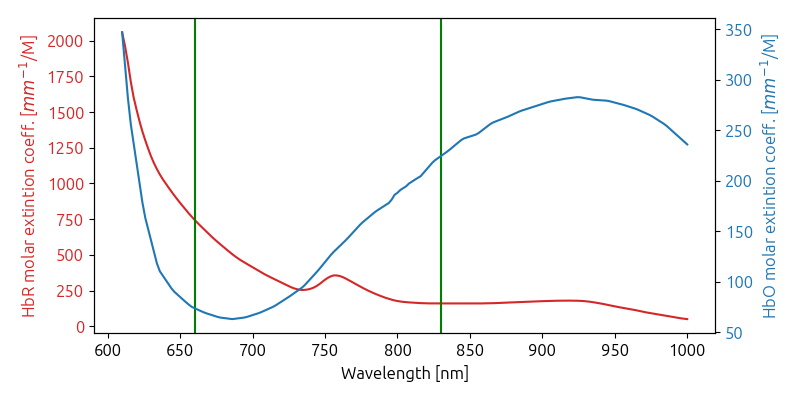

In [9]:
lambdas = [660, 830]

spectraHbR = "hbr.dat"
spectraHbO = "hbo.dat"

concHbO = 1 #g/ml
concHbR = 1 #g/ml

spectraArrayHbR = np.loadtxt(spectraHbR)
spectraArrayHbO = np.loadtxt(spectraHbO)



font = {'family': 'ubuntu',
        'weight': 'regular',
        'size': 12}

plt.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('HbR molar extintion coeff. [$mm^{-1}$/M]', color=color)
ax1.plot(spectraArrayHbR[:, 0][180:], aux.movingAverage(spectraArrayHbR[:, 1][180:],5) / concHbR, color=color, label="HbR")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Relative absorption', color=color)  # we already handled the x-label with ax1
ax2.plot(spectraArrayHbO[:, 0][180:], spectraArrayHbO[:, 1][180:] / concHbO, color=color, label="HbO")
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("HbO molar extintion coeff. [$mm^{-1}$/M]")

fig.tight_layout()  # otherwise the right y-label is slightly clipped



for l in lambdas:
    ax1.axvline(x=l, color='green')

plt.savefig("HbSpectra.png", bbox_inches='tight', dpi=300)



In [10]:
imRaw = np.zeros((np.shape(reconCC1_660)[0], np.shape(reconCC1_660)[1], 2))
imRaw[:,:,0] = reconCC1_660
imRaw[:,:,1] = reconCC1_830

cropSize = 250

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos, cropSize, cropSize, spectraData1 = spectraHbR, spectraData2 = spectraHbO, 
                              concentration1=concHbR, concentration2=concHbO, ua=0.002)
    
desOxyMap_CC1_2D = HbXMaps_2D[:,:,0]
OxyMap_CC1_2D = HbXMaps_2D[:,:,1]
TotMap_CC1_2D = desOxyMap_CC1_2D + OxyMap_CC1_2D

Step 1/2...


100%|██████████| 250/250 [00:37<00:00,  6.63it/s]


Step 2/2...


100%|██████████| 58/58 [03:31<00:00,  3.65s/it]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [11]:
# Flip to match real positions

desOxyMap_CC1_2D = np.flip(desOxyMap_CC1_2D, axis=1)
OxyMap_CC1_2D = np.flip(OxyMap_CC1_2D, axis=1)
TotMap_CC1_2D = np.flip(TotMap_CC1_2D, axis=1)


#desOxyMap_CC1_2D_filtered = ndimage.median_filter(desOxyMap_CC1_2D,10)
#OxyMap_CC1_2D_filtered = ndimage.median_filter(OxyMap_CC1_2D,10)

#desOxyMap_CC1_2D_filtered = aux.fftGauss(desOxyMap_CC1_2D,5)[0]
#OxyMap_CC1_2D_filtered = aux.fftGauss(OxyMap_CC1_2D,5)[0]

desOxyMap_CC1_2D_filtered = desOxyMap_CC1_2D
OxyMap_CC1_2D_filtered = OxyMap_CC1_2D

desOxyMap_CC1_2D_filtered[np.isnan(desOxyMap_CC1_2D_filtered)] = 0
OxyMap_CC1_2D_filtered[np.isnan(OxyMap_CC1_2D_filtered)] = 0

np.savetxt("desOxyMap_CC1.dat", desOxyMap_CC1_2D_filtered)
np.savetxt("OxyMap_CC1.dat", OxyMap_CC1_2D_filtered)

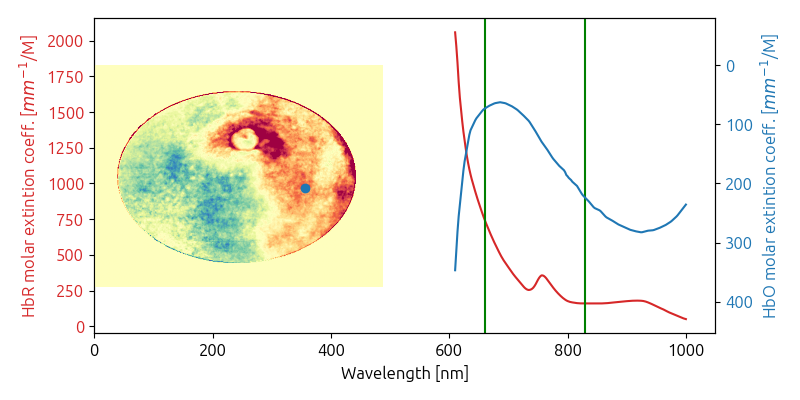

In [12]:
sd = np.nanstd(OxyMap_CC1_2D_filtered)
median = np.nanmedian(OxyMap_CC1_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd
plt.imshow(OxyMap_CC1_2D_filtered, cmap=mp.colormaps[colorMap], vmax = vmax, vmin = vmin)
plt.scatter(356,208)
plt.show()

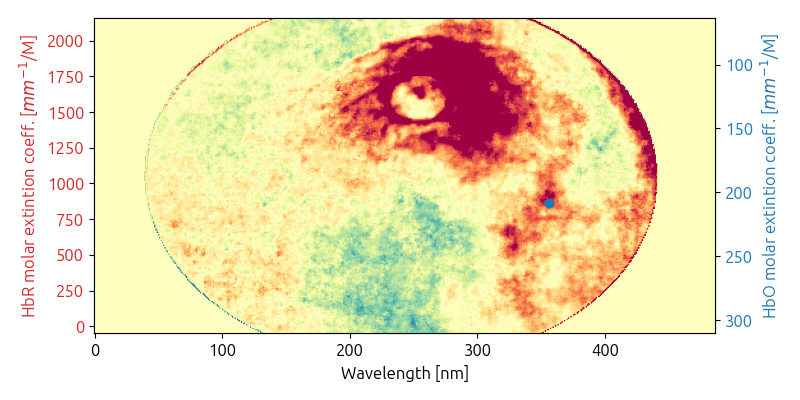

In [13]:
sd = np.nanstd(desOxyMap_CC1_2D_filtered)
median = np.nanmedian(desOxyMap_CC1_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd
plt.imshow(desOxyMap_CC1_2D_filtered, cmap=mp.colormaps[colorMap], vmax = vmax, vmin = vmin)
plt.show()

In [24]:
interestPositions = [[206,356], [235,363], [270,239]]

interestSaturations = []
for i in interestPositions:
    iSat = aux.O2Sat(OxyMap_CC1_2D_filtered[i[0], i[1]], desOxyMap_CC1_2D_filtered[i[0], i[1]])
    interestSaturations.append(int(iSat))
    print("Oxygen saturation in {},{} is {}%".format(i[1],i[0],iSat))

Oxygen saturation in 356,206 is 65.0%
Oxygen saturation in 363,235 is 83.0%
Oxygen saturation in 239,270 is 80.0%


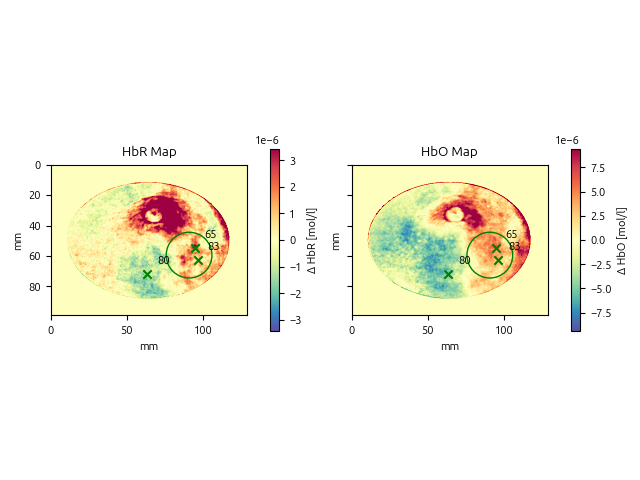

In [25]:

font = {'family': 'ubuntu',
        'weight': 'regular',
        'size': 8}

mp.rc('font', **font)

doTotMap = False

scale = 3.77
extent = [0, int(np.shape(desOxyMap_CC1_2D_filtered)[1]/scale),
          int(np.shape(desOxyMap_CC1_2D_filtered)[0]/scale), 0]

incPosition = (342/scale, 224/scale)
incRadius = 15


if doTotMap:
    figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(
        1, 3, sharex=True, sharey=True)
    font["size"] = 6
    mp.rc('font', **font)
else:
    figSats, ((DesOxy, Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

sd = np.nanstd(desOxyMap_CC1_2D_filtered)
median = np.nanmedian(desOxyMap_CC1_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd

figDesOxy = DesOxy.imshow(desOxyMap_CC1_2D_filtered,
                          cmap=mp.colormaps[colorMap], vmax=vmax, vmin=vmin, extent=extent)
circle = patches.Circle(incPosition, radius=incRadius,
                        edgecolor='green', facecolor='none')

DesOxy.add_patch(circle)

for i in range(len(interestPositions)):
    DesOxy.scatter(interestPositions[i][1]/scale,
                   interestPositions[i][0]/scale, marker="x", c="green")
    DesOxy.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )

DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")


sd = np.nanstd(OxyMap_CC1_2D_filtered)
median = np.nanmedian(OxyMap_CC1_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd


figOxy = Oxy.imshow(OxyMap_CC1_2D_filtered,
                    cmap=mp.colormaps[colorMap], vmax=vmax, vmin=vmin, extent=extent)
circle = patches.Circle(incPosition, radius=incRadius,
                        edgecolor='green', facecolor='none')
Oxy.add_patch(circle)

for i in range(len(interestPositions)):
    Oxy.scatter(interestPositions[i][1]/scale,
                interestPositions[i][0]/scale, marker="x", c="green")
    Oxy.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )

c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
    TotMap_CC1_2D = desOxyMap_CC1_2D_filtered + OxyMap_CC1_2D_filtered

    sd = np.nanstd(TotMap_CC1_2D)
    median = np.nanmedian(TotMap_CC1_2D)
    vmax = median + maxDev * sd
    vmin = median - maxDev * sd

    figTot = Tot.imshow(TotMap_CC1_2D, vmin=vmin, vmax=vmax,
                        cmap=mp.colormaps[colorMap], extent=extent)
    circle = patches.Circle(incPosition, radius=incRadius,
                            edgecolor='green', facecolor='none')
    Tot.add_patch(circle)

    for i in range(len(interestPositions)):
        Tot.scatter(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale, marker="x", c="green")
        Tot.annotate(str(interestSaturations[i]), xy=(interestPositions[i][1]/scale,
                    interestPositions[i][0]/scale), xytext=(10,10), textcoords="offset pixels" )
        
    c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
    c3.set_label("Δ HbTot [mol/l]")
    Tot.set_xlabel("mm")
    Tot.set_ylabel("mm")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

if doTotMap:
    Tot.set_title("Total HB HBMap")


figSats.tight_layout()

plt.show()
figSats.savefig("CC1_HbMaps_noTot.png", bbox_inches='tight', dpi=300)
